<a href="https://colab.research.google.com/github/RaphaelAN/-github-react-challenge/blob/master/Redes_Advers%C3%A1rias_Generativas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Adversárias Generativas 

**Feito por Raphael Accioly Novello.**


email: raphael.novello@gmail.com


Redes Adverśarias Generativas são um tipo de rede neural proposto originalmente por Ian Goodfellow em um artigo de 2014 [Generative Adversarial Networks](https://https://arxiv.org/abs/1406.2661) que tem como objetivo gerar dados baseados em um conjunto de exemplos de treino. Nesse projeto farei o uso de tais redes para criar novas imagens de digitos (0-9) baseados no [MNIST Database](https://http://yann.lecun.com/exdb/mnist/).


![MNIST_example](https://knowm.org/wp-content/uploads/Screen-Shot-2015-08-14-at-2.44.57-PM.png)

#Descrição da Rede

As Redes Adversárias Generativas são um modelo de rede neural que atravez da competição entre duas redes treinadas simultanemaente é capaz de gerar novos dados baseados no dataset de treino a partir de uma seed aleatoria. Essas redes são chamadas de adversárias pois "competem" uma com a outra. Uma, chamada de geradora, cria novas imagens a partir de um vetor seed aleatorio enquanto que a outra chamada de discriminadora tenta descobrir se essas imagens são parte do dataset original ou foram geradas pela geradora.

![Net_example](https://i2.wp.com/deeplearningbook.com.br/wp-content/uploads/2019/09/GANs-1.png?w=1213&ssl=1)

### Função de Custo

A [função de custo](https://https://www.youtube.com/watch?v=IHZwWFHWa-w&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=2) de uma rede neural é a função utilizada para determinar o erro da rede ao realizar a tarefa desejada com o objetivo de minimiza-lo atravez do algoritimo de [backpropagation](https://https://deeplearningbook.com.br/algoritmo-backpropagation-parte1-grafos-computacionais-e-chain-rule/). Em nosso caso a função de custo da 
rede discriminadora, que  tem como output a probabilidade da imagem dada como input ser do dataset original, é o quadrado da diferença entre a resposta que ela deu e a resposta correta (nesse caso a resposta correta sera 0 ou 1 determinando se a imagem é ou não parte do dataset original). Já a rede generativa é treinada a partir do inverso dessa função de custo, ou seja, quanto melhor a rede discriminadora for em relação a sua função de custo pior a rede generativa vai e vice versa. Por isso essas redes são chamadas de adversárias.

### Função de Ativação

A rede que sera criada usara o modelo de neurônios sigmoid, ou seja, sera aplicada ,aos outputs, a transformação não linear da função sigmoid: $$\frac{1}{1 + e ^{-x}} $$ Usar essa função garante que pequenas mudanças nos pesos e bias da rede causarão apenas pequenas mudanças nos outputs. Isso garante que seja possível o aprendizado da rede atravez do calculo da [descida do gradiente](https://https://deeplearningbook.com.br/aprendizado-com-a-descida-do-gradiente/) algo que não seria possível com os outputs binarios de Perceptrons, por exemplo.

#### Sigmoid
![Função Sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/SigmoidFunction.png/400px-SigmoidFunction.png)





# Metodologia

Para a construção da rede sera utilizada a biblioteca [PyTorch](https://https://pytorch.org/) e as referências citadas abaixo:


1.   [Coding a Generative Adversarial Network (GAN) for MNIST \[Python with Tensorflow\]](https://https://www.youtube.com/watch?v=Xehr9TBeJv4)
2.   [Neural Networks and Deep Learning](https://http://neuralnetworksanddeeplearning.com/chap1.html)
3.   [Make Your Own Algorithmic Art](https://makeyourownalgorithmicart.blogspot.com/)

Primariamente sera criado uma rede de classificação basica capaz de reconhecer os digitos do dataset MNIST, com isso teremos um modelo para o discriminador que saberemos sera capaz de fazer a classificação binaria consideravelmente mais simples de se a imagem é ou não parte do dataset original com input de 784 nodes, correspondentes aos pixeis da imagem, e output binario. Depois sera criado o modelo da rede geradora que sera baseado nos mesmos neurônios sigmoid, com input a ser determinado por testes e output (vetor seed aleatorio) de 784 nodes correspondentes a cada pixel da imagem gerada.


# Programando a rede classificadora

Redes neurais não são nada mais que multiplicações de matrizes. Ou seja em sua simplificação mais basica podemos considerar redes neurais tranformações lineares.

No nosso caso ao criar um dicriminador temos um vetor em $R^{784}$ como input correspondendo a cada pixel da imagem e um vetor em $R^{10}$ como output correspondendo a probabilidade da imagem corresponder a cada digito (0-9)

In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets

#fazendo o download do dataset
train = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))



In [ ]:
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test)

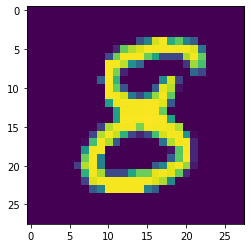

In [ ]:
import matplotlib.pyplot as plt

#podemos ver aqui um exemplo de uma imagem no nosso set de treino
for data in trainset:
    plt.imshow(data[0][0].view(28,28))
    plt.show()
    break

In [ ]:
import torch.nn as nn 
import torch.nn.functional as F
import pandas

class Classifier(nn.Module):

    def __init__(self):
        super().__init__()

        # definindo os layers da rede
        self.model = nn.Sequential(
            nn.Linear(784,200),
            nn.LeakyReLU(),
            nn.Linear(200,10),
            nn.Softmax(dim = 1)
        )

        # função de custo
        self.error_function = torch.nn.MSELoss()

        # otimizador usando gradiente
        self.otimizador = torch.optim.Adam(self.parameters(), lr=0.01) 

        self.counter = 0
        self.items = 0
        self.score = 0
        self.progress = []
        self.accuracy = []
        pass

        #roda a rede. "faz a transformação linear"
    def foward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        output = self.foward(inputs)

        custo = self.error_function(output, targets)

         #incrementa o contador e acumula o custo
        self.counter += 1
        for i in range(len(output)):
                if(output[i].argmax() == targets[i].argmax()):
                    self.score += 1
                    pass
                self.items += 1
                pass

        if(self.counter % 5 == 0):
            self.progress.append(custo.item())
            self.accuracy.append(self.score/self.items)
            self.items = 0
            self.score = 0
            pass

        if(self.counter % 1000 == 0):
            print("counter = ", self.counter)
            #self.progress.append(self.test(testset))
            pass

        # faz a propagação e atualiza os pesos
        self.otimizador.zero_grad()
        custo.backward()
        self.otimizador.step()
        pass

    #test trained network

    def test(self, inputs):
        score = 0
        items = 0
        for data in inputs:
            image_data_vector, label = data
            anwser = self.foward(image_data_vector.view(-1,784).detach())
            if(anwser.argmax() == label):
                score += 1
                pass
            items += 1
            pass
        return score/items

    def save(self, path):
        self.load_state_dict(torch.load(path))
        pass

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['custo'])
        df.plot(ylim=(0, 0.120), figsize=(16,8), alpha=1.5, marker='.', grid=True, yticks=(0, 0.060, 0.120))
        pass
    
    def plot_accuracy(self):
        df = pandas.DataFrame(self.accuracy, columns=['accuracy'])
        df.plot(ylim=(0.0, 1.0), figsize=(16,8), alpha=1.5, marker='.', grid=True, yticks=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0))
        pass

    pass


In [ ]:
# treinando o classificador

Classificador = Classifier()

epochs = 3
progress = []
for i in range(epochs):
    print ('treinando epoch', i + 1, "of", epochs)
    for data in trainset:
        image_data_vector, labels = data
        target_vector = F.one_hot(labels,num_classes= 10)
        target_vector = target_vector.float()
        Classificador.train(image_data_vector.view(-1,784), target_vector)
        pass
    progress.append(Classificador.test(testset))
    pass

treinando epoch 1 of 3
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
treinando epoch 2 of 3
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
treinando epoch 3 of 3
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000


[0.8837, 0.889, 0.86]


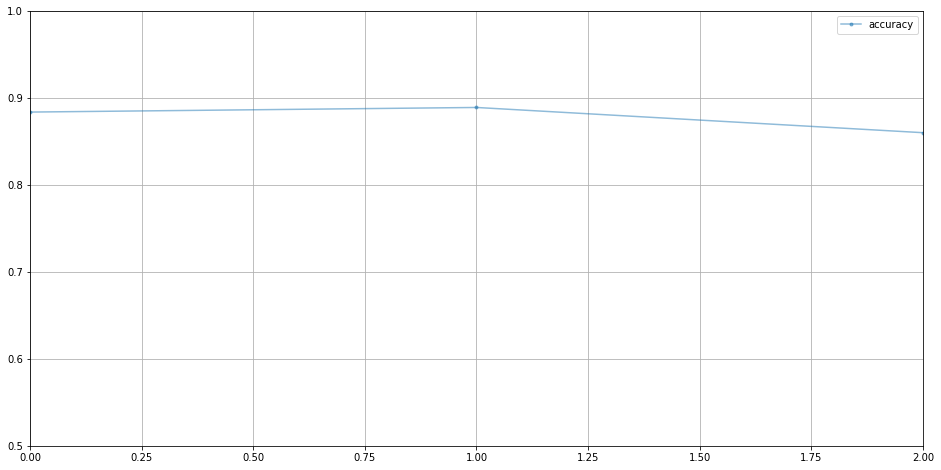

In [ ]:
 print (progress)
 
 def plot_progress(progress):
        df = pandas.DataFrame(progress, columns=['accuracy'])
        df.plot(ylim=(0.5, 1.0), figsize=(16,8), alpha=1.5, marker='.', grid=True, yticks=(0.5,0.6,0.7,0.8,0.9,1.0))
        pass
plot_progress(progress)

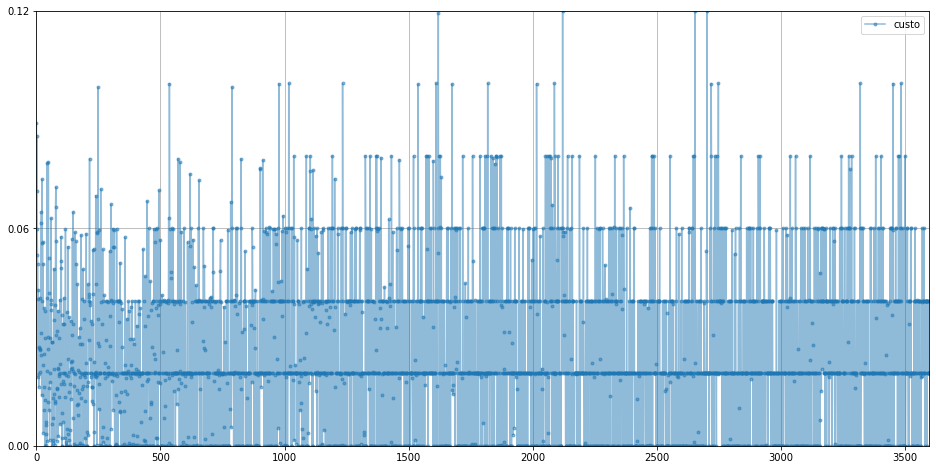

In [ ]:
Classificador.plot_progress()

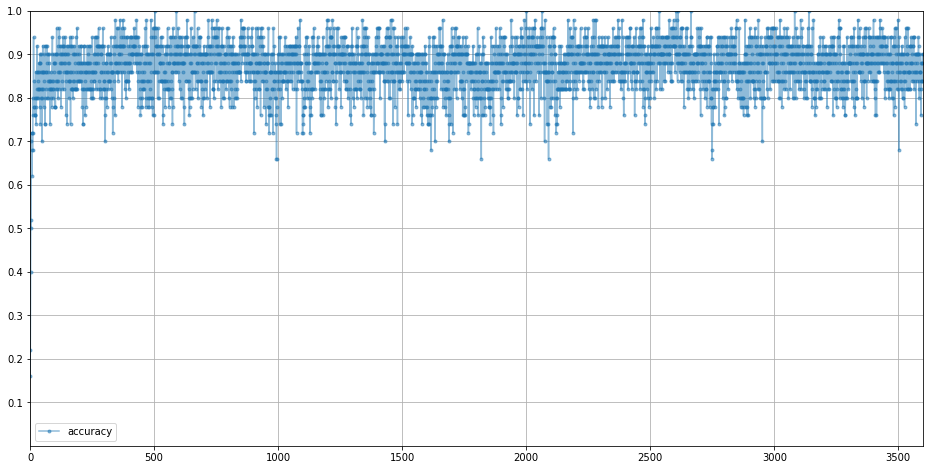

In [ ]:
Classificador.plot_accuracy()

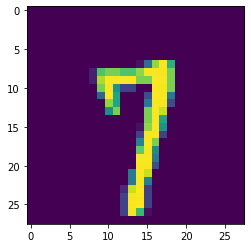

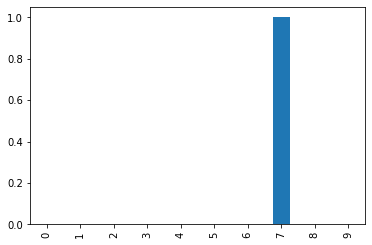

In [ ]:
#test trained network

for data in trainset:
    image_data = data[0][0]

    #testando uma imagem
    plt.imshow((image_data.view(28,28)))
    plt.show()

    # visualisando a resposta da rede

    pandas.DataFrame(Classificador.foward(image_data.view(-1,784))[0].detach().numpy()).plot(kind='bar', legend=False)
    break

    

# Criando a GAN

Para criar a GAN fiz primeiro o modelo do discriminador e o testei com imagens reais e falsas. 

### Criando o Discriminador

O discriminador é apenas uma versão simplificada do classificador criado acima. Em vez de um output de 10 dimensões correspondendo aos digitos [0-9] agora temos como output apenas um numero de 0 a 1 que indicara a probabilidade da imagem ser verdadeira.

In [ ]:
class NeuralNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.counter = 0
        self.items = 0
        self.score = 0
        self.progress = []
        self.accuracy = []
        pass

    #roda a rede. "faz a transformação linear"
    def foward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        pass

    #test trained network
    def test(self, inputs):
        pass

    def save(self, path):
        self.load_state_dict(torch.load(path))
        pass

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['custo'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=1.5, marker='.', grid=True, yticks=(0, 0.060, 0.120))
        pass
    
    def plot_accuracy(self):
        df = pandas.DataFrame(self.accuracy, columns=['accuracy'])
        df.plot(ylim=(0.0, 1.0), figsize=(16,8), alpha=1.5, marker='.', grid=True, yticks=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0))
        pass

    pass

In [ ]:
# criando a classe da rede descriminadora

class Discriminator(NeuralNet):

    def __init__(self):
        super().__init__()

        # definindo os layers da rede
        self.model = nn.Sequential(
            nn.Linear(784,200),
            nn.LeakyReLU(),

            nn.LayerNorm(200,200),

            nn.Linear(200,1),
            nn.Sigmoid()
        )

        # função de custo
        self.error_function = torch.nn.MSELoss()

        # otimizador usando gradiente
        self.otimizador = torch.optim.Adam(self.parameters(), lr=0.001)


    #test trained network
    def test(self, inputs):
        score = 0
        items = 0
        for data in inputs:
            image_data_vector, label = data
            anwser = self.foward(image_data_vector.view(-1,784).detach())
            if(anwser.argmax() == label):
                score += 1
                pass
            items += 1
            pass
        return score/items

    def train(self, inputs, targets):
        output = self.foward(inputs)

        custo = self.error_function(output, targets)

        #incrementa o contador e acumula o custo
        self.counter += 1
        for i in range(len(output)):
                if(output[i].argmax() == targets[i].argmax()):
                    self.score += 1
                    pass
                self.items += 1
                pass

        if(self.counter % 5 == 0):
            self.progress.append(custo.item())
            self.accuracy.append(self.score/self.items)
            self.items = 0
            self.score = 0
            pass

        if(self.counter % 1000 == 0):
            #print("counter = ", self.counter)
            #self.progress.append(self.test(testset))
            pass
        return custo

    def backpropagate(self, loss):
        # faz a propagação e atualiza os pesos
        self.otimizador.zero_grad()
        loss.backward(retain_graph= True)
        self.otimizador.step()
        pass

In [ ]:
#testando o descriminador com dados gerados

Discriminador = Discriminator()

progress = []
epochs = 3
batch_size = 10
for i in range(epochs):
    print ('treinando epoch', i + 1, "of", epochs)
    for data in trainset:
        #treinando nas imagens reais 
        image_data_vector, labels = data
        target_vector = torch.ones((10,1), dtype=torch.float32)
        real_loss = Discriminador.train(image_data_vector.view(-1,784), target_vector)
        

        #treinando nas imagens falsas
        random_image = torch.randn(10,784).float()
        random_target = torch.zeros((10,1), dtype=torch.float32)
        fake_loss = Discriminador.train(random_image, random_target)
        Discriminador.backpropagate(real_loss + fake_loss)
        pass
    progress.append(Classificador.test(testset))
    pass

treinando epoch 1 of 3
treinando epoch 2 of 3
treinando epoch 3 of 3


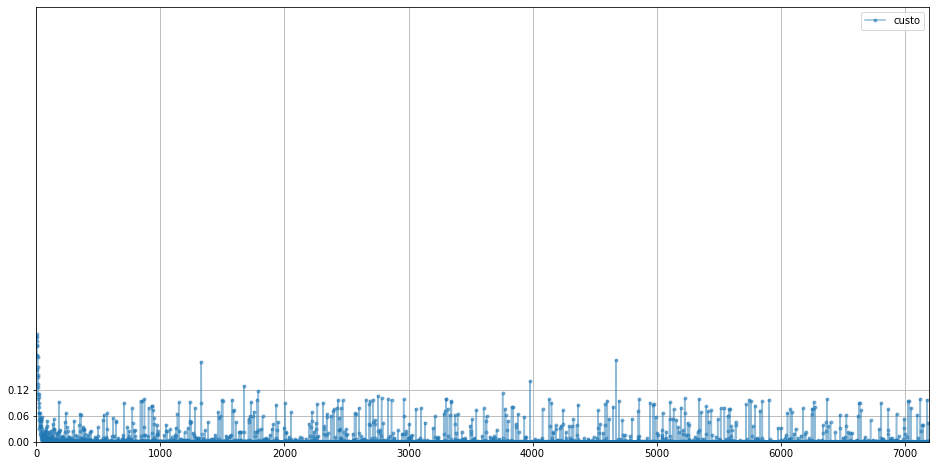

In [ ]:
Discriminador.plot_progress()

torch.Size([1, 1])
Probabilidade estimada de ser real:  tensor([[8.3231e-09]], grad_fn=<SigmoidBackward>)


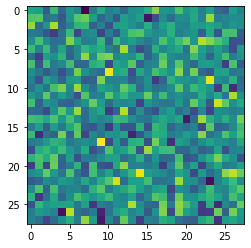

Probabilidade estimada de ser real:  tensor([[1.]], grad_fn=<SigmoidBackward>)


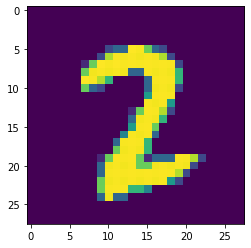

In [ ]:
print(Discriminador.foward(torch.randn(1,784)).size())
for data in trainset:
    #testando uma imagem falsa 
    print("Probabilidade estimada de ser real: ",Discriminador.foward(torch.randn(1,784).view(-1,784)))
    plt.imshow(torch.randn(1,784).view(28,28))
    plt.show()

    #testando uma imagem real 
    print("Probabilidade estimada de ser real: ",Discriminador.foward(data[0][0].view(-1,784)))
    plt.imshow((data[0][0].view(28,28)))
    plt.show()
    break


### Criando o Gerador

In [ ]:
class Generator(NeuralNet):
    def __init__(self):
        super().__init__()

        # definindo os layers da rede
        self.model = nn.Sequential(
            nn.Linear(100,500),
            nn.LeakyReLU(0.2),

            nn.LayerNorm(500,500),

            nn.Linear(500,784),
            nn.Sigmoid()
        )

        # função de custo
        self.error_function = torch.nn.MSELoss()

        # otimizador usando gradiente
        self.otimizador = torch.optim.Adam(self.parameters(), lr=0.001)


    def train(self, Discriminador, inputs, targets):
        g_output = self.foward(inputs)

        d_output = Discriminador.foward(g_output)

        custo = Discriminador.error_function(d_output, targets)

         #incrementa o contador e acumula o custo
        self.counter += 1
        #for i in range(len(output)):
                #if(output[i].argmax() == targets[i].argmax()):
                #    self.score += 1
                #    pass
        #        self.items += 1
        #        pass

        if(self.counter % 5 == 0):
            self.progress.append(custo.item())
            #self.accuracy.append(self.score/self.items)
            self.items = 0
            self.score = 0
            pass

        if(self.counter % 1000 == 0):
            print("counter = ", self.counter)
            #self.progress.append(self.test(testset))
            pass

        # faz a propagação e atualiza os pesos
        self.otimizador.zero_grad()
        custo.backward()
        self.otimizador.step()
        pass

      #test trained network

    def test(self, inputs):
        score = 0
        items = 0
        for data in inputs:
            image_data_vector, label = data
            anwser = self.foward(image_data_vector.view(-1,784).detach())
            if(anwser.argmax() == label):
                score += 1
                pass
            items += 1
            pass
        return score/items

    def plot_images(self):
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(self.foward(torch.randn(100)).detach().cpu().numpy().reshape(28,28), interpolation='none', cmap='Blues')
                pass
            pass
        pass

torch.Size([10, 784])


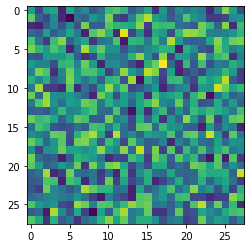

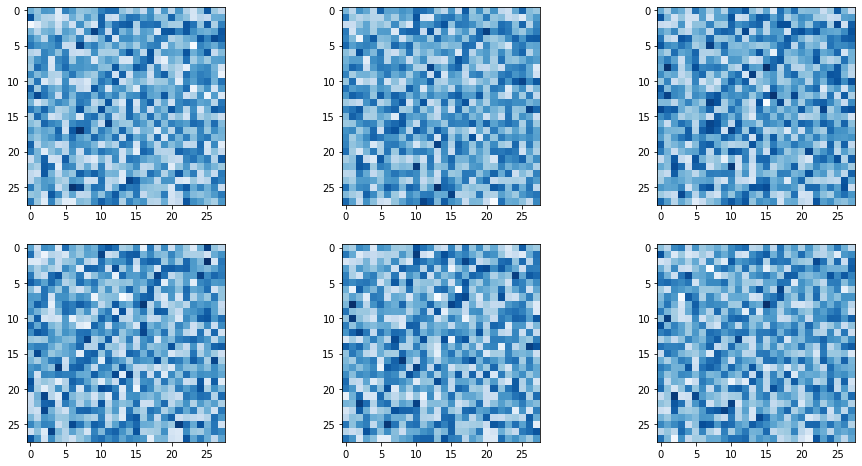

In [ ]:
Gerador = Generator()
images = Gerador.foward(torch.randn(10,100)).detach().cpu().numpy().reshape(10,28,28)
print(Gerador.foward(torch.randn(10,100)).detach().size())
for image in images:
    plt.imshow(image)
    plt.show()
    break
    
Gerador.plot_images()

In [ ]:
#testando a rede

Discriminador = Discriminator()
Gerador = Generator()

D_progress = []
G_progress = []
epochs = 100
batch_size = 10
for i in range(epochs):
    print ('treinando epoch', i + 1, "of", epochs)
    for data in trainset:
        #treinando nas imagens reais 
        image_data_vector, labels = data
        target_vector = torch.ones((batch_size,1), dtype=torch.float32)
        real_loss = Discriminador.train(image_data_vector.view(-1,784), target_vector)

        #treinando nas imagens falsas
        random_image = Gerador.foward(torch.randn(batch_size,100)).detach()
        random_target = torch.zeros((batch_size,1), dtype=torch.float32)
        fake_loss = Discriminador.train(random_image, random_target)

        Discriminador.backpropagate(real_loss + fake_loss)

        #treinando o Gerador
        Gerador.train(Discriminador, torch.randn(batch_size,100), target_vector)
        pass

    #progress.append(Gerador.test(testset))
    Gerador.plot_images()
    pass

treinando epoch 1 of 100


Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode= size=0x0 at 0x7FF633EBEDA0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 584, in __del__
    def __del__(self):
KeyboardInterrupt


counter =  1000


KeyboardInterrupt: ignored

In [ ]:
Gerador.plot_images()

In [ ]:


Discriminador.plot_progress()

In [ ]:
Gerador.plot_progress()

In [ ]:
images = Gerador.foward(torch.randn(10,100)).detach().cpu().numpy().reshape(10,28,28)
print(Gerador.foward(torch.randn(10,100)).detach().size())
for image in images:
    plt.imshow(image)
    plt.show()
    break

In [ ]:
new_digit = Gerador.foward(torch.randn(1,100)).detach()
plt.imshow(new_digit.view(28,28))
plt.show()
Classificador.foward(Gerador.foward(torch.randn(1,100)).detach())

pandas.DataFrame(Classificador.foward(new_digit)[0].detach().numpy()).plot(kind='bar', legend=False)

# Bibliografia



1.   [Generative Adversarial Networks](https://https://arxiv.org/abs/1406.2661)
2.   [MNIST Database](https://http://yann.lecun.com/exdb/mnist/)
3.   [Função de Custo](https://https://www.youtube.com/watch?v=IHZwWFHWa-w&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=2)
4.   [Backpropagation](https://https://deeplearningbook.com.br/algoritmo-backpropagation-parte1-grafos-computacionais-e-chain-rule/)
5.   [PyTorch](https://https://pytorch.org/)
1.   [Descida do Gradiente](https://https://deeplearningbook.com.br/aprendizado-com-a-descida-do-gradiente/) 
6.   [Coding a Generative Adversarial Network (GAN) for MNIST \[Python with Tensorflow\]](https://https://www.youtube.com/watch?v=Xehr9TBeJv4)
7.   [Neural Networks and Deep Learning](https://http://neuralnetworksanddeeplearning.com/chap1.html)
8.   [Make Your Own Algorithmic Art](https://makeyourownalgorithmicart.blogspot.com/)


